<a href="https://colab.research.google.com/github/siddu49/Minor_Project/blob/main/Mini_Project_Final_Combined.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install spectral vit-pytorch

In [2]:
# Importing Libraries
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.io import loadmat
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix, classification_report, cohen_kappa_score,balanced_accuracy_score
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from vit_pytorch import ViT

In [3]:
dataset = 'IP'
if dataset == 'IP':
    data_file = 'indian_pines_corrected.mat'
    gt_file = 'indian_pines_gt.mat'
    data_key = 'indian_pines_corrected'
    gt_key = 'indian_pines_gt'
    num_classes = 16
    class_names = [
        "Alfalfa", "Corn-notill", "Corn-mintill", "Corn", "Grass-pasture", "Grass-trees",
        "Grass-pasture-mowed", "Hay-windrowed", "Oats", "Soybean-notill", "Soybean-mintill",
        "Soybean-clean", "Wheat", "Woods", "Buildings-Grass-Trees-Drives", "Stone-Steel-Towers"
    ]
    model_save_path = 'model_using_ip_dataset.pth'
elif dataset == 'PU':
    data_file = 'PaviaU.mat'
    gt_file = 'PaviaU_gt.mat'
    data_key = 'paviaU'
    gt_key = 'paviaU_gt'
    num_classes = 9
    class_names = [
        "Asphalt", "Meadows", "Gravel", "Trees", "Painted metal sheets", "Bare Soil",
        "Bitumen", "Self-Blocking Bricks", "Shadows"
    ]
    model_save_path = 'model_using_pu_dataset.pth'
else:
    raise ValueError("Dataset not recognized")

In [4]:
# Loading The Dataset
data = loadmat(data_file)[data_key]
gt = loadmat(gt_file)[gt_key]

print(f"Data shape: {data.shape}")
print(f"Ground truth shape: {gt.shape}")

Data shape: (145, 145, 200)
Ground truth shape: (145, 145)


In [5]:
# Data Normalization
data_norm = (data - np.min(data)) / (np.max(data) - np.min(data))

In [6]:
# PCA Reduction to 3 Components
D = 3
reshaped = data_norm.reshape(-1, data_norm.shape[-1])
pca = PCA(n_components=D)
reshaped_pca = pca.fit_transform(reshaped)
data_pca = reshaped_pca.reshape(data_norm.shape[0], data_norm.shape[1], D)
print(f"PCA data shape: {data_pca.shape}")

PCA data shape: (145, 145, 3)


In [7]:
def extract_patches(img, gt, size=25, stride=5):
    patches = []
    labels = []
    pad_width = size // 2

    img_padded = np.pad(img, ((pad_width, pad_width), (pad_width, pad_width), (0, 0)), mode='constant')

    for i in range(gt.shape[0]):
        for j in range(gt.shape[1]):
            center_label = gt[i, j]

            if center_label != 0:
                patch = img_padded[i : i + size, j : j + size, :]
                patches.append(patch)
                labels.append(center_label - 1)

    return np.array(patches), np.array(labels)

patches, labels = extract_patches(data_pca, gt, size=25, stride=1)
print(f"Extracted {len(patches)} patches")

Extracted 10249 patches


In [8]:
# Data Augmentation
def augment_data(patches, labels):
    augmented_patches = []
    augmented_labels = []

    for patch, label in zip(patches, labels):
        augmented_patches.append(patch)
        augmented_labels.append(label)

        patch_flip = np.flip(patch, axis=1).copy()
        augmented_patches.append(patch_flip)
        augmented_labels.append(label)

        patch_flip_v = np.flip(patch, axis=0).copy()
        augmented_patches.append(patch_flip_v)
        augmented_labels.append(label)

    return np.array(augmented_patches), np.array(augmented_labels)

patches_aug, labels_aug = augment_data(patches, labels)
print(f"After augmentation: {patches_aug.shape}")

After augmentation: (30747, 25, 25, 3)


In [9]:
# Dataset Preparation
X_tensor = torch.FloatTensor(patches_aug).permute(0, 3, 1, 2)
y_tensor = torch.LongTensor(labels_aug)
X_train, X_test, y_train, y_test = train_test_split(
    X_tensor, y_tensor, test_size=0.3, random_state=42, stratify=y_tensor
)
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
print(f"Training: {len(X_train)}, Testing: {len(X_test)}")

Training: 21522, Testing: 9225


In [10]:
# Vision Transformer Model
model = ViT(
    image_size=25,
    patch_size=5,
    num_classes=num_classes,
    channels=3,
    dim=64,
    depth=3,
    heads=4,
    mlp_dim=128,
    dropout=0.25,
    emb_dropout=0.25
)

In [11]:
# Training Setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3,
    weight_decay=1e-5  )

In [12]:
# Training
train_losses = []
train_accuracies = []
epochs = 60
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for data, target in train_loader:
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        _, predicted = output.max(1)
        total += target.size(0)
        correct += predicted.eq(target).sum().item()
    epoch_loss = running_loss / len(train_loader)
    epoch_acc = 100. * correct / total
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_acc)
    print(f'Epoch [{epoch+1}/{epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.2f}%')


Epoch [1/60], Loss: 1.1241, Accuracy: 60.30%
Epoch [2/60], Loss: 0.5798, Accuracy: 79.63%
Epoch [3/60], Loss: 0.4203, Accuracy: 85.44%
Epoch [4/60], Loss: 0.3385, Accuracy: 88.29%
Epoch [5/60], Loss: 0.2801, Accuracy: 90.28%
Epoch [6/60], Loss: 0.2437, Accuracy: 91.62%
Epoch [7/60], Loss: 0.2209, Accuracy: 92.31%
Epoch [8/60], Loss: 0.1951, Accuracy: 93.26%
Epoch [9/60], Loss: 0.1779, Accuracy: 93.81%
Epoch [10/60], Loss: 0.1680, Accuracy: 94.01%
Epoch [11/60], Loss: 0.1547, Accuracy: 94.64%
Epoch [12/60], Loss: 0.1493, Accuracy: 94.74%
Epoch [13/60], Loss: 0.1340, Accuracy: 95.32%
Epoch [14/60], Loss: 0.1351, Accuracy: 95.39%
Epoch [15/60], Loss: 0.1255, Accuracy: 95.63%
Epoch [16/60], Loss: 0.1258, Accuracy: 95.54%
Epoch [17/60], Loss: 0.1075, Accuracy: 96.30%
Epoch [18/60], Loss: 0.1045, Accuracy: 96.32%
Epoch [19/60], Loss: 0.0979, Accuracy: 96.64%
Epoch [20/60], Loss: 0.1075, Accuracy: 96.29%
Epoch [21/60], Loss: 0.0929, Accuracy: 96.79%
Epoch [22/60], Loss: 0.0893, Accuracy: 96.9

In [13]:
# Evaluation
model.eval()
all_preds = []
all_labels = []
with torch.no_grad():
    correct = 0
    total = 0
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        outputs = model(data)
        _, predicted = outputs.max(1)

        total += target.size(0)
        correct += predicted.eq(target).sum().item()

        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(target.cpu().numpy())
accuracy = 100. * correct / total
print(f'Overall Accuracy: {accuracy:.2f}%')

aa = balanced_accuracy_score(all_labels, all_preds)
print(f"Average Accuracy (AA): {aa * 100:.2f}%")

kappa = cohen_kappa_score(all_labels, all_preds)
print(f"Cohen's Kappa: {kappa:.4f}")


print("\nClassification Report:")
print(classification_report(all_labels, all_preds,
                            labels=range(num_classes),
                            target_names=class_names,
                            zero_division=0))


Overall Accuracy: 98.58%
Average Accuracy (AA): 98.94%
Cohen's Kappa: 0.9838

Classification Report:
                              precision    recall  f1-score   support

                     Alfalfa       1.00      1.00      1.00        41
                 Corn-notill       0.99      1.00      0.99      1285
                Corn-mintill       0.99      1.00      0.99       747
                        Corn       0.99      1.00      0.99       213
               Grass-pasture       0.94      0.98      0.96       435
                 Grass-trees       0.91      1.00      0.95       657
         Grass-pasture-mowed       0.93      1.00      0.96        25
               Hay-windrowed       1.00      1.00      1.00       430
                        Oats       0.95      1.00      0.97        18
              Soybean-notill       1.00      1.00      1.00       875
             Soybean-mintill       1.00      0.99      1.00      2210
               Soybean-clean       1.00      0.98      0.9

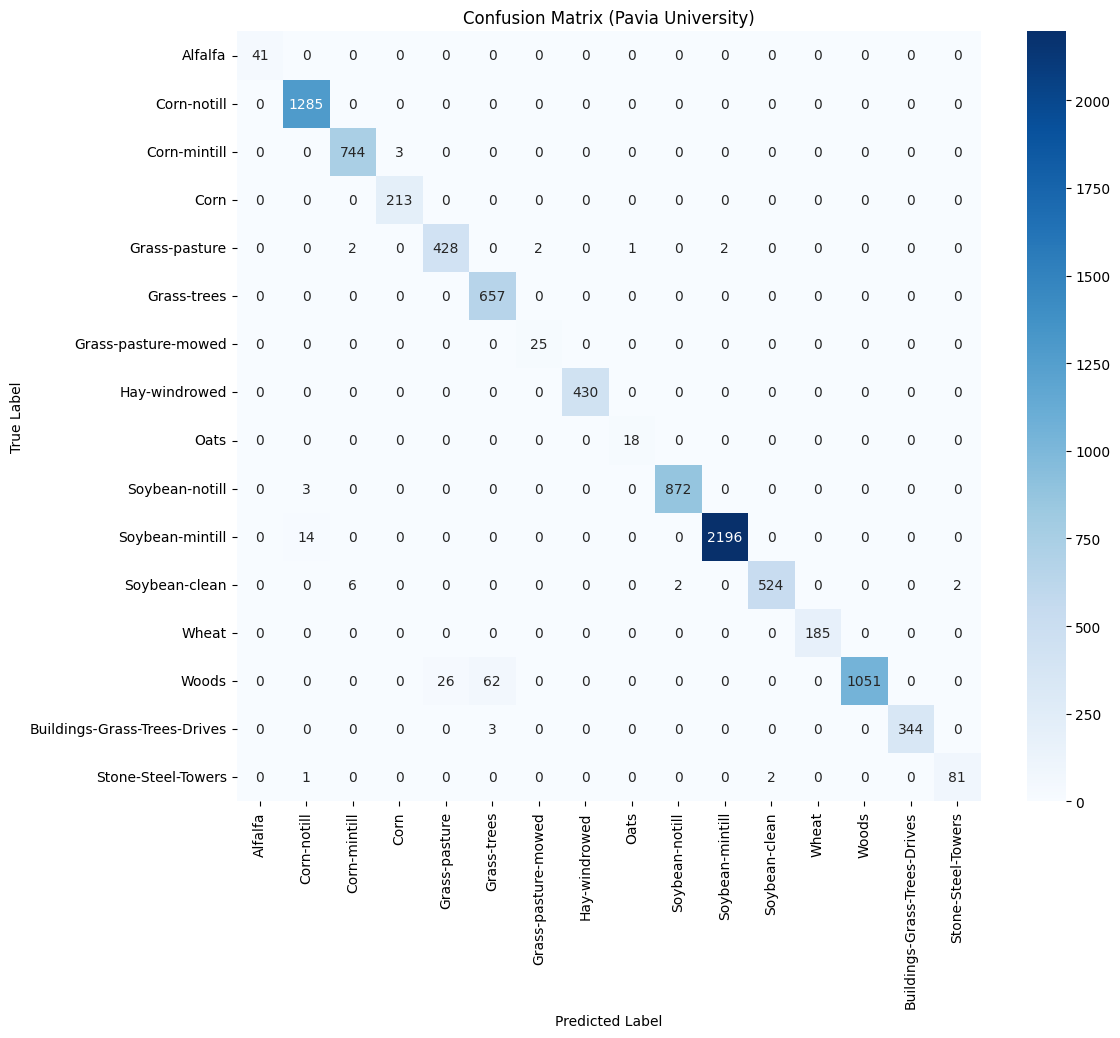

In [14]:
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names)

plt.title('Confusion Matrix (Pavia University)')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()


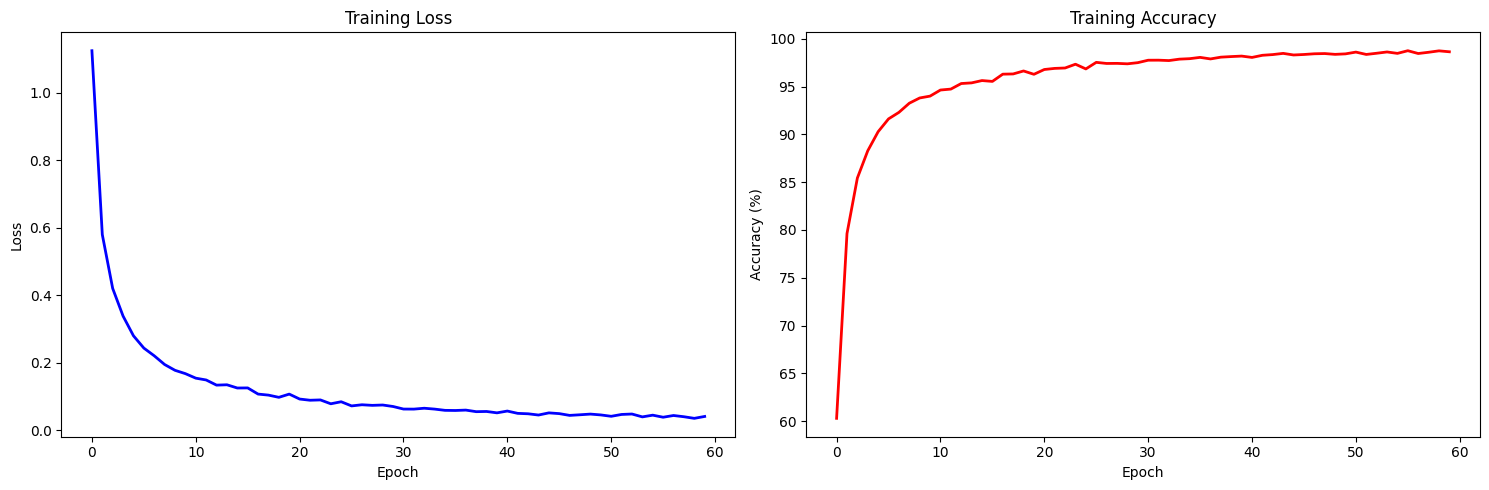

In [15]:

# Training Visualization
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, 'b-', linewidth=2)
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, 'r-', linewidth=2)
plt.title('Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.tight_layout()
plt.show()


In [16]:
# Save Model
torch.save(model.state_dict(), model_save_path)
print("Model saved successfully!")

Model saved successfully!


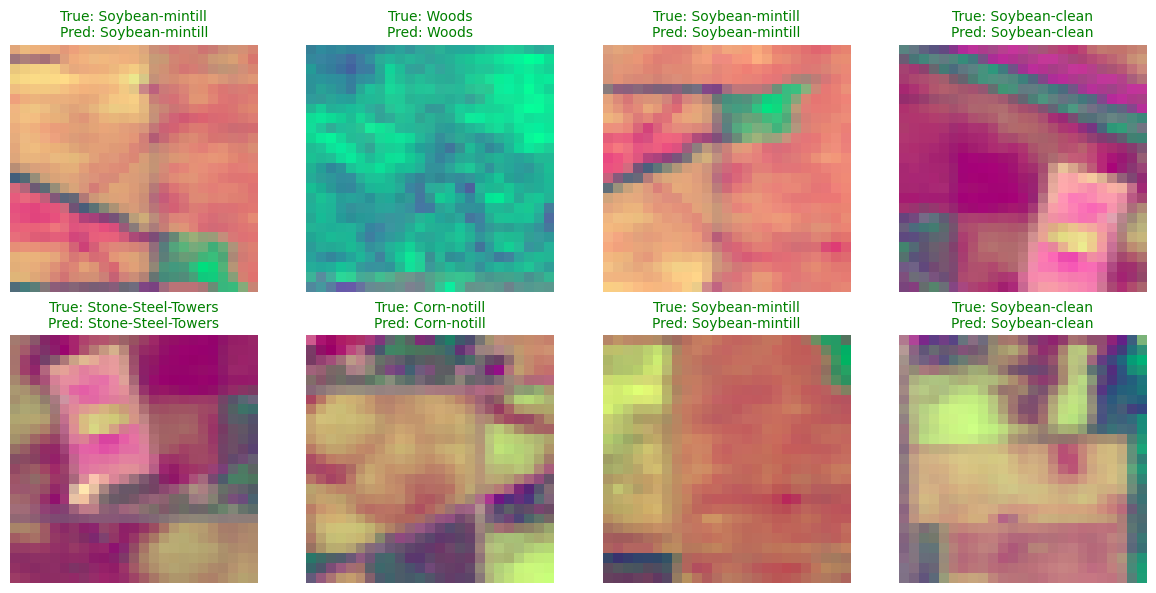

In [17]:
# Predictions vs Ground Truth
sample_indices = np.random.choice(len(X_test), 8, replace=False)

fig, axes = plt.subplots(2, 4, figsize=(12, 6))
for idx, sample_idx in enumerate(sample_indices):
    sample_data = X_test[sample_idx].unsqueeze(0).to(device)
    true_label = y_test[sample_idx].item()

    with torch.no_grad():
        pred = model(sample_data).argmax(dim=1).item()

    patch_rgb = sample_data[0].cpu().permute(1, 2, 0).numpy()
    patch_rgb = (patch_rgb - patch_rgb.min()) / (patch_rgb.max() - patch_rgb.min())

    axes[idx//4, idx%4].imshow(patch_rgb)
    color = 'green' if true_label == pred else 'red'
    axes[idx//4, idx%4].set_title(f'True: {class_names[true_label]}\nPred: {class_names[pred]}', color=color, fontsize=10)
    axes[idx//4, idx%4].axis('off')

plt.tight_layout()
plt.show()